# Setup and data download

In [1]:
import yfinance as yf
import pandas as pd
import datetime
import numpy as np
from scipy import stats
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import yahooquery as yq
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import tqdm
sns.set_style("whitegrid")
DARK_COL = "#6876a4"
LIGHT_COL = "#f0b64d"

In [2]:
######### Load fama french data ###########
ff = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3_daily.csv")
ff = ff.rename({"Unnamed: 0": "Date"}, axis = 1)
ff["Date"] = pd.to_datetime(ff["Date"], format="ISO8601")
ff

,Date,Mkt-RF,SMB,HML,RMW,CMA,RF
0,1963-07-01,-0.67,0.02,-0.35,0.03,0.13,0.012
1,1963-07-02,0.79,-0.28,0.28,-0.08,-0.21,0.012
2,1963-07-03,0.63,-0.18,-0.10,0.13,-0.25,0.012
3,1963-07-05,0.40,0.09,-0.28,0.07,-0.30,0.012
4,1963-07-08,-0.63,0.07,-0.20,-0.27,0.06,0.012
...,...,...,...,...,...,...,...
15036,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016
15037,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016
15038,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016
15039,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016


In [3]:
######### Get returns of S&P 500 stocks ###########

# Get tickers of S&P 500
def list_wikipedia_sp500() -> pd.DataFrame:
    # Ref: https://stackoverflow.com/a/75845569/
    url = 'https://en.m.wikipedia.org/wiki/List_of_S%26P_500_companies'
    return pd.read_html(url, attrs={'id': 'constituents'}, index_col='Symbol')[0]

tickers = list(list_wikipedia_sp500().index) + ["^GSPC"]

# Download data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data = yf.download(tickers, start = start, end = end)
prices = data["Adj Close"].reset_index()
# Drop columns without any data
prices = prices.drop(["BF.B", "BRK.B", "HON"], axis=1)

# Compute log-prices and log-returns
returns = prices.copy()
returns.iloc[:,1:] = np.log(prices.iloc[:,1:])
Returns = np.diff(returns.iloc[:,1:],axis=0)*100  #times 100 so we get returns in percentage 
# We assume the first return to be 0
Returns = np.vstack((np.zeros(Returns.shape[1]),Returns))
returns.iloc[:,1:] = Returns
# Isolate S&P 500
sp500 = returns[["Date","^GSPC"]]
returns = returns.drop("^GSPC", axis = 1)
returns

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092195,10.724583,-0.596170,0.172762,NaN,-0.716046,-0.811215,-0.334110,0.616123,...,5.904128,-1.193010,0.389720,-1.195930,NaN,-0.342556,3.116492,-0.174548,3.465168,NaN
2,2010-01-06,-0.355936,-4.231421,0.868194,-1.603419,NaN,-0.950022,0.553778,-0.433244,1.057476,...,-1.320371,0.191868,0.860581,0.656682,NaN,-0.717496,-0.032269,-0.771667,8.338132,NaN
3,2010-01-07,-0.129714,2.904378,-0.024723,-0.185060,NaN,-1.616673,0.825047,-0.589966,-0.093553,...,2.113119,-0.432238,-0.314687,1.300503,NaN,-0.028782,2.268099,-2.531778,10.616030,NaN
4,2010-01-08,-0.032462,-1.926859,0.394523,0.662645,NaN,1.080663,0.509940,-0.197437,-0.398541,...,-0.719062,0.048148,-0.401955,0.000000,NaN,0.028782,-2.122788,-0.325557,-1.631954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


In [4]:
# Merge dataframes based on date
df = pd.merge(ff, returns, on = "Date", how = "inner", suffixes=["_FF", ""])
df

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,1.69,0.79,1.13,-0.17,0.21,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,0.31,-0.41,1.24,-0.19,0.19,0.000,-1.092195,10.724583,-0.596170,...,5.904128,-1.193010,0.389720,-1.195930,NaN,-0.342556,3.116492,-0.174548,3.465168,NaN
2,2010-01-06,0.13,-0.13,0.57,-0.05,0.20,0.000,-0.355936,-4.231421,0.868194,...,-1.320371,0.191868,0.860581,0.656682,NaN,-0.717496,-0.032269,-0.771667,8.338132,NaN
3,2010-01-07,0.40,0.25,0.98,-0.69,0.22,0.000,-0.129714,2.904378,-0.024723,...,2.113119,-0.432238,-0.314687,1.300503,NaN,-0.028782,2.268099,-2.531778,10.616030,NaN
4,2010-01-08,0.33,0.32,0.01,0.22,-0.37,0.000,-0.032462,-1.926859,0.394523,...,-0.719062,0.048148,-0.401955,0.000000,NaN,0.028782,-2.122788,-0.325557,-1.631954,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.27,0.51,1.02,-0.28,0.35,0.016,0.837650,1.590773,3.467113,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.17,-0.03,0.74,0.08,0.55,0.016,-0.331202,0.286533,0.867762,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,1.39,-0.34,-0.50,-0.90,-0.54,0.016,0.915649,2.612226,1.551751,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.51,-0.61,-0.59,0.20,-0.09,0.016,0.477010,0.832759,0.897704,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


# 1. Do a regression using the Fama french factors for each stock excess returns and store the estimated coefficients, their t-statistics, and the R squared in a 500 x 13 matrix.

In [5]:
def prepare_data_ols(df):
    ff_columns = ["Mkt-RF", "SMB", "HML", "RMW", "CMA_FF"]
    X = df[ff_columns]
    X = sm.add_constant(X)
    return X

X = prepare_data_ols(df)
X

,const,Mkt-RF,SMB,HML,RMW,CMA_FF
0,1.0,1.69,0.79,1.13,-0.17,0.21
1,1.0,0.31,-0.41,1.24,-0.19,0.19
2,1.0,0.13,-0.13,0.57,-0.05,0.20
3,1.0,0.40,0.25,0.98,-0.69,0.22
4,1.0,0.33,0.32,0.01,0.22,-0.37
...,...,...,...,...,...,...
3329,1.0,0.27,0.51,1.02,-0.28,0.35
3330,1.0,-0.17,-0.03,0.74,0.08,0.55
3331,1.0,1.39,-0.34,-0.50,-0.90,-0.54
3332,1.0,0.51,-0.61,-0.59,0.20,-0.09


In [8]:
def ols_estimation(df, X, returns):
    beta_names = [f"beta_{var}" for var in X.columns]
    tvalue_names = [f"t_{var}" for var in X.columns]
    stocks = returns.columns[1:] # Excludes Date

    df_ols_results = pd.DataFrame(np.zeros((len(stocks), 13+1)), columns = ["stock"] + beta_names + tvalue_names + ["R2"])

    for i, stock in enumerate(stocks):
        # Get dependent variable y: excess returns of stock (X stays the same for every stock)
        y = df[stock] - df["RF_FF"]
        ols = sm.OLS(endog=y, exog=X, missing = "drop")
        ols_results = ols.fit()
        coefs = ols_results.params
        t_stats = ols_results.tvalues
        r2 = ols_results.rsquared
        df_ols_results.iloc[i, 0] = stock
        df_ols_results.iloc[i, 1:] = np.concatenate([coefs,t_stats,[r2]])

    return df_ols_results

df_ols_results = ols_estimation(df, X, returns)
df_ols_results.head()

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,-0.002305,1.147959,0.042658,-0.177300,-0.233550,0.126152,-0.109376,57.002618,1.119716,-4.897162,-4.606577,1.814005,0.555602
1,AAL,-0.026688,1.273091,0.834769,0.770070,0.242065,-0.354722,-0.558791,27.894755,9.668789,9.385565,2.106812,-2.250746,0.302043
2,AAP,-0.015915,0.842018,0.328667,0.037590,0.583782,0.039670,-0.533398,29.532889,6.093733,0.733373,8.133289,0.402924,0.250085
3,AAPL,0.025276,1.178569,-0.175438,-0.497186,0.595587,-0.023429,1.187735,57.955283,-4.560402,-13.599524,11.633598,-0.333630,0.539743
4,ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082057,0.368701,0.967089,28.303811,-2.715751,-2.667287,1.187556,3.975079,0.245479


# 2. Compute descriptive statistics for each of the 13 columns of the previous question.

In [9]:
# Get discriptive statistics of dataframe
df_ols_results.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.001070,0.999381,0.140293,0.177703,0.089973,0.003839,-0.085085,42.773906,2.086385,4.501253,2.099612,0.440163,0.429733
std,0.033113,0.216044,0.299821,0.498204,0.324845,0.426939,0.924701,12.759202,6.125492,12.265352,5.324258,5.450591,0.134704
min,-0.086930,0.440067,-0.548381,-0.920035,-1.137032,-1.556368,-2.743258,2.348168,-15.501232,-16.779481,-19.895201,-17.911656,0.058644
25%,-0.016873,0.847333,-0.097875,-0.164749,-0.062509,-0.215519,-0.698176,34.722018,-2.327989,-4.124569,-1.062606,-2.495661,0.331104
50%,-0.001784,1.001999,0.109268,0.097894,0.148759,0.058547,-0.079938,41.245207,2.524029,2.320315,2.278879,0.685812,0.426387
75%,0.012642,1.146461,0.336663,0.388928,0.324796,0.290819,0.532678,50.602804,6.652103,8.613389,6.168714,3.649560,0.522387
max,0.324967,1.675626,1.357604,1.807274,0.888307,0.971785,2.458251,83.367572,17.323111,52.439309,14.599561,14.323311,0.783296


# 3. Compute nonparametric density estimates for each of the 13 t-statistics (you have about 500 values for each statistic) and make plots. Comment.

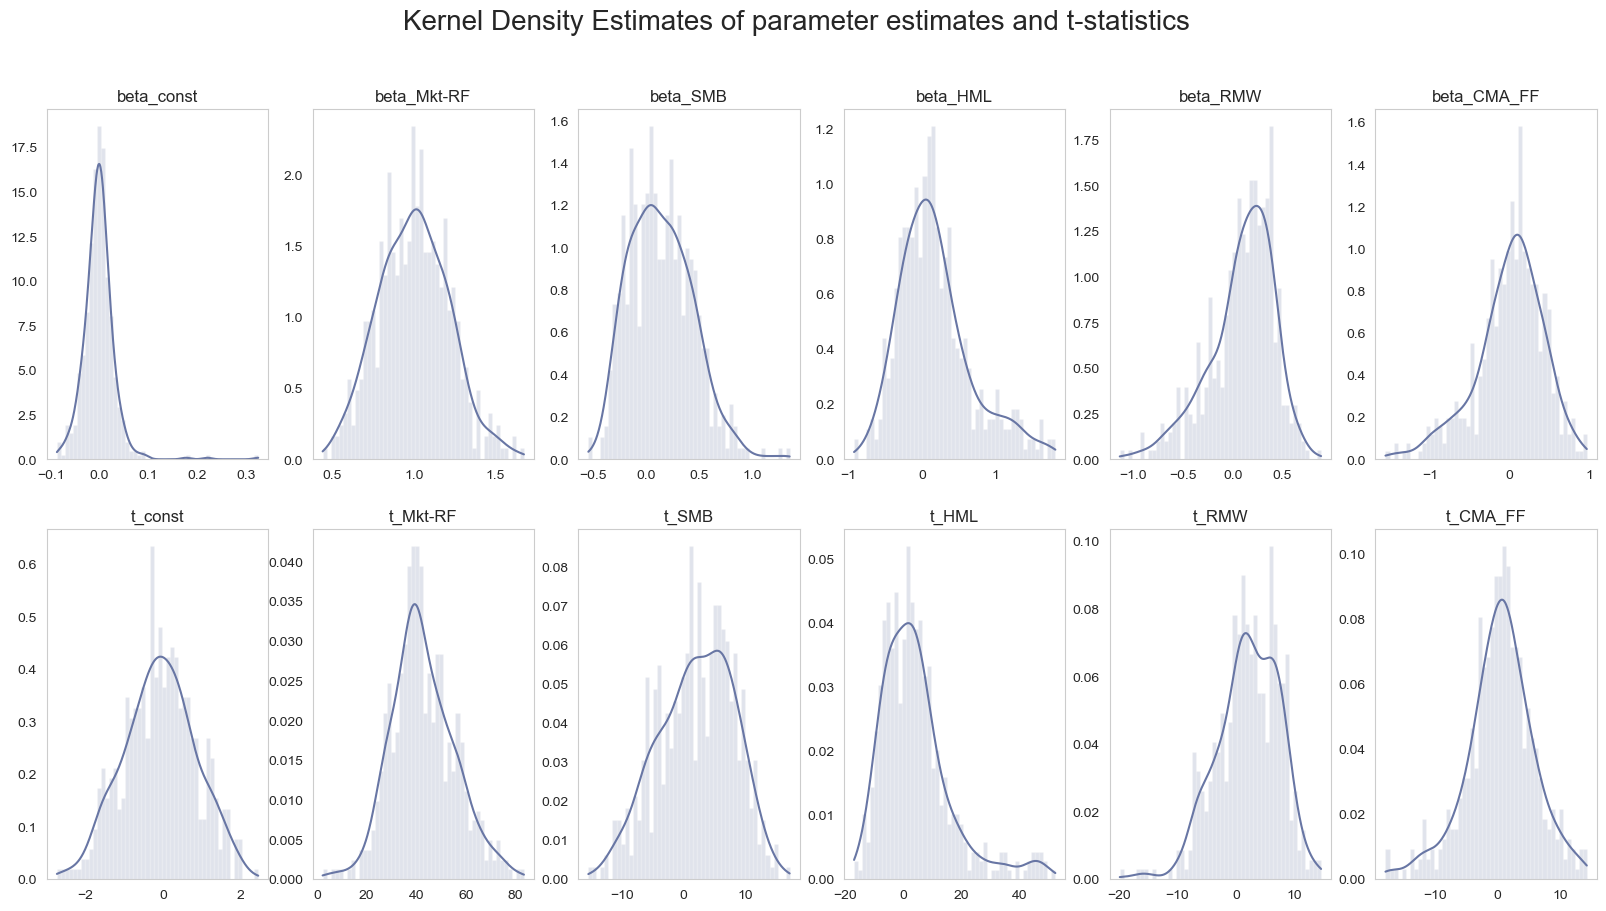

In [38]:
def kde_statistics(df_ols_results, df_ols_results2 = None):
    # Create histograms of estimate and every t-statistic
    fig, axs = plt.subplots(2, 6, figsize = (20, 10))
    axs = axs.reshape(-1)
    colnames = df_ols_results.columns[1:]

    for i, ax in enumerate(axs):
        if i >= len(colnames):
            break
        vals = df_ols_results.iloc[:,1+i]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        ax.plot(ind, kdepdf, label='Daily', color = DARK_COL)
        ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
        ax.grid(False)
        ax.set_title(colnames[i])
        if not df_ols_results2 is None:
            vals = df_ols_results2.iloc[:,1+i]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals),max(vals),500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label='Monthly', color = LIGHT_COL, ls = "--")
            ax.legend()
            ax.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
    plt.suptitle("Kernel Density Estimates of parameter estimates and t-statistics", size = 20)
    plt.show()

kde_statistics(df_ols_results)

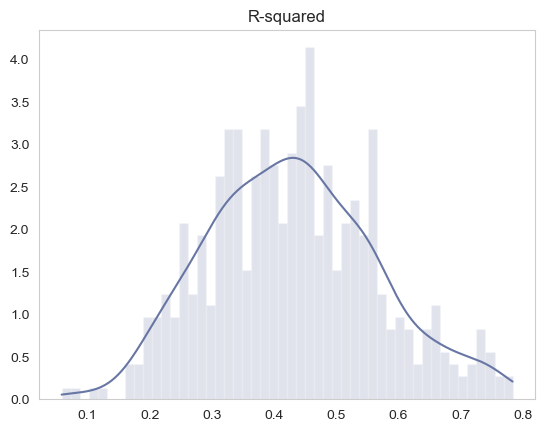

In [98]:
def plot_r_squared(df_ols_results, df_ols_results_monthly = None):
    # Plot R-squared
    vals = df_ols_results["R2"]
    d = stats.gaussian_kde(vals)
    ind = np.linspace(min(vals),max(vals),500)
    kdepdf = d.evaluate(ind)
    plt.plot(ind, kdepdf, label='Daily', color = DARK_COL)
    plt.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
    if not df_ols_results_monthly is None:
        vals = df_ols_results_monthly["R2"]
        d = stats.gaussian_kde(vals)
        ind = np.linspace(min(vals),max(vals),500)
        kdepdf = d.evaluate(ind)
        plt.plot(ind, kdepdf, label='Monthly', color = LIGHT_COL, ls = "--")
        plt.hist(vals, density = True, bins = 50, color = LIGHT_COL, alpha = 0.2)
        plt.legend()
    plt.grid(False)
    plt.title("R-squared")
    plt.show()

plot_r_squared(df_ols_results)

**Comment:** From these plots we can make the following observations.

First of all, a lot of the coefficient estimates of the FF-factors seem to statistically significant. The factor that is clearly the most important is $R_m - R_f$, with the t-statistic distribution having a mean of around 40. This means that in almost all cases the market factor has a positive impact on the stock returns. Furthermore we observe that the t-statistics are generally greater (in absolute value) than 1.96, which means that we reject the hypothesis that the factors have no impact on the excess returns. Indeed, the t-statistics for SMB, HML, RMW and CMA have a large range (on average -15 to 15) with a distribution that is fairly normal.

In fact we observe that most parameter estimates seem to be relatively normally distributed, with the exception of HML and RMW, which have a parameter distribution that is skewed to the right and left respectively. Since the corresponding t-statistics are merely a scaled version of the parameter estimates, it is not surprising that most t-statistics are normally distributed as well.

The R-squared distribution estimate looks fairly normal, with a mean of around 0.4. That indicates that the FF-factors can explain (on average) 40% of the total variance of excess returns.

# 4. How differ the estimated factor coefficients according to the 11 sectors of the Global Industry Classification Standard?

In [13]:
def add_sector(df):
    df = df.copy()
    stocks = df["stock"]
    df["sector"] = ""
    for i, stock in enumerate(tqdm.tqdm(stocks)):
        ticker = yf.Ticker(stock)
        try:
            sector = ticker.get_info()["sector"]
        except KeyError:
            print(f"No sector found for {stock}")
        df.iloc[i, -1] = sector
    return df

In [14]:
df_results_sector = add_sector(df_ols_results)

  0%|          | 0/500 [00:00<?, ?it/s]

 16%|█▌        | 80/500 [00:12<01:09,  6.05it/s]

No sector found for CAT


 54%|█████▍    | 271/500 [00:45<00:40,  5.72it/s]

No sector found for L


100%|██████████| 500/500 [01:21<00:00,  6.10it/s]


0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin


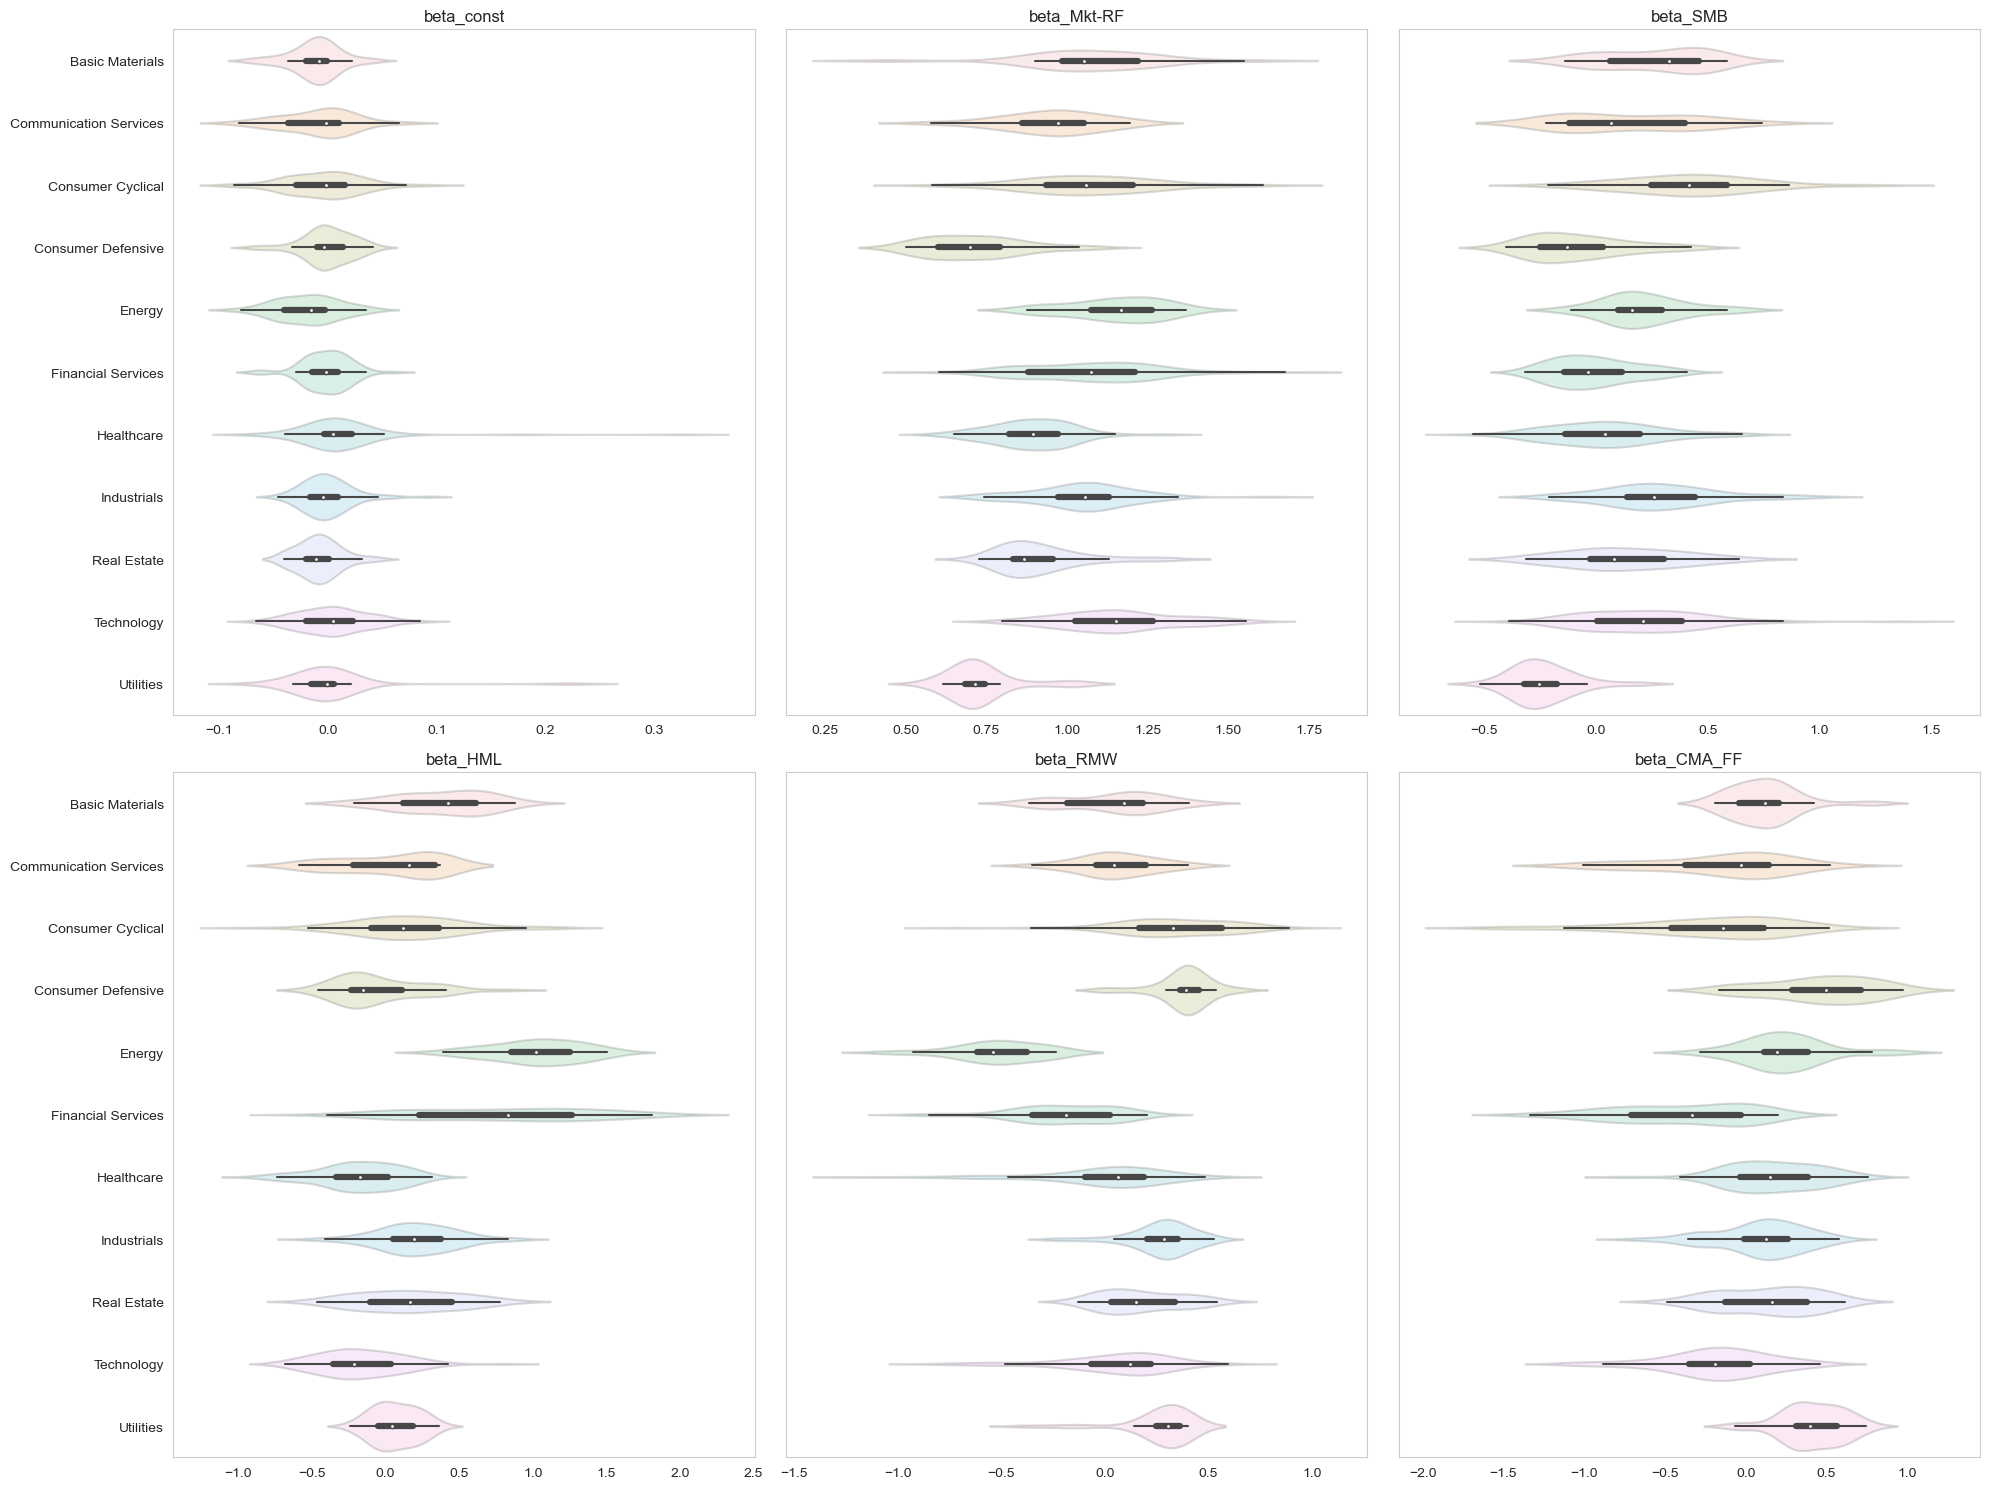

In [144]:
def plot_violin_sector(df, df2 = None):
    monthly_daily = False
    if not df2 is None:
        monthly_daily = True
    sns.set_style("whitegrid")
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15), sharey=True, squeeze=True)
    #plt.close('all')
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    

    for i, ax in enumerate(axs):
        D = pd.pivot(df[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
        ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None if monthly_daily else "box", orient = "h", ax=ax, color = "grey" if monthly_daily else None)
        for violin in ax.collections[::2]:
            print(i, "violin")
            violin.set_alpha(0.2)
        if not df2 is None:
            #for violin in ax.collections[::2]:
            #    violin.set_alpha(0.2)
            D = pd.pivot(df2[[coef_names[i], "sector"]],columns='sector', values=coef_names[i])
            ax = sns.violinplot(D, widths=2, showmeans=True, showmedians=False, showextrema=False, inner = None, orient = "h", ax=ax)
            for violin in ax.collections[::2]:
                print(i, "violin")
                violin.set_alpha(0.2)
        ax.set_ylabel("")
        ax.grid(False)
        ax.set_title(coef_names[i])
    plt.tight_layout()
    

plot_violin_sector(df_results_sector)

**Comment** 

In these plots we can observe the distribution of the distribution of each coefficient for every sector. For the constant we do not observe a considerable difference. That being said, for the other coefficients, we observe differences among all sectors. For instance, for the market factor, we see that consumer cyclical and utilies are less influenced by the market, whereas sectors like Energy and Technology are heavily market-influenced with an average coefficient above 1. That being said, we observe that all sectors are positively influenced by the market.

 **ADD COMMENT**

In [16]:
def plot_kde_sector(df):
    # Create histograms of estimates for every industry
    fig, axs = plt.subplots(2, 3, figsize = (20, 15))
    axs = axs.reshape(-1)
    coef_names = df_ols_results.columns[1:(len(axs)+1)]
    sns.set_style("whitegrid")


    for sector in df["sector"].unique():
        df_sector = df_ols_results[df["sector"] == sector]
        for i, ax in enumerate(axs):
            vals = df_sector.iloc[:,i+1]
            d = stats.gaussian_kde(vals)
            ind = np.linspace(min(vals)-0.2,max(vals) + 0.3,500)
            kdepdf = d.evaluate(ind)
            ax.plot(ind, kdepdf, label=sector)
            #ax.hist(vals, density = True, bins = 50, color = DARK_COL, alpha = 0.2)
            ax.legend()
            ax.grid(False)
            ax.set_title(coef_names[i])
            #plt.show()

# 5. Is it possible to cluster the stocks in groups in an unsupervised way? How many clusters do you recommend and what are typical characteristics of each cluster.

## 5.1 Clustering based on FF-coefficients

In [15]:
df_ff_clustering = df_ols_results.copy()
cols_of_interest = df_ols_results.columns[:13]
df_ff_clustering = df_ff_clustering[cols_of_interest]
df_ff_clustering.index = df_ff_clustering["stock"].values
df_ff_clustering = df_ff_clustering.drop("stock", axis = 1)
df_ff_clustering

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF
A,-0.002305,1.147959,0.042656,-0.177300,-0.233549,0.126154,-0.109378,57.002607,1.119677,-4.897167,-4.606562,1.814028
AAL,-0.026688,1.273091,0.834769,0.770070,0.242065,-0.354722,-0.558791,27.894751,9.668785,9.385564,2.106812,-2.250751
AAP,-0.015915,0.842018,0.328666,0.037590,0.583782,0.039669,-0.533398,29.532905,6.093716,0.733381,8.133291,0.402918
AAPL,0.025276,1.178569,-0.175437,-0.497186,0.595588,-0.023430,1.187735,57.955261,-4.560376,-13.599525,11.633606,-0.333642
ABBV,0.028364,0.791503,-0.140691,-0.128710,0.082056,0.368704,0.967088,28.303818,-2.715752,-2.667295,1.187537,3.975105
...,...,...,...,...,...,...,...,...,...,...,...,...
YUM,0.007844,0.855561,-0.030756,0.042027,0.327987,0.066488,0.371543,42.407814,-0.805868,1.158748,6.457756,0.954370
ZBH,-0.018393,0.860477,0.193156,0.166984,0.117460,-0.168360,-0.829152,40.593157,4.816861,4.381838,2.201080,-2.300000
ZBRA,0.005819,1.202005,0.416916,-0.265489,0.188217,-0.103430,0.193632,41.857025,7.674556,-5.142510,2.603470,-1.043000
ZION,-0.003125,1.049921,0.337522,1.631794,-0.552389,-0.945908,-0.130749,45.974131,7.812706,39.745612,-9.607994,-11.994488


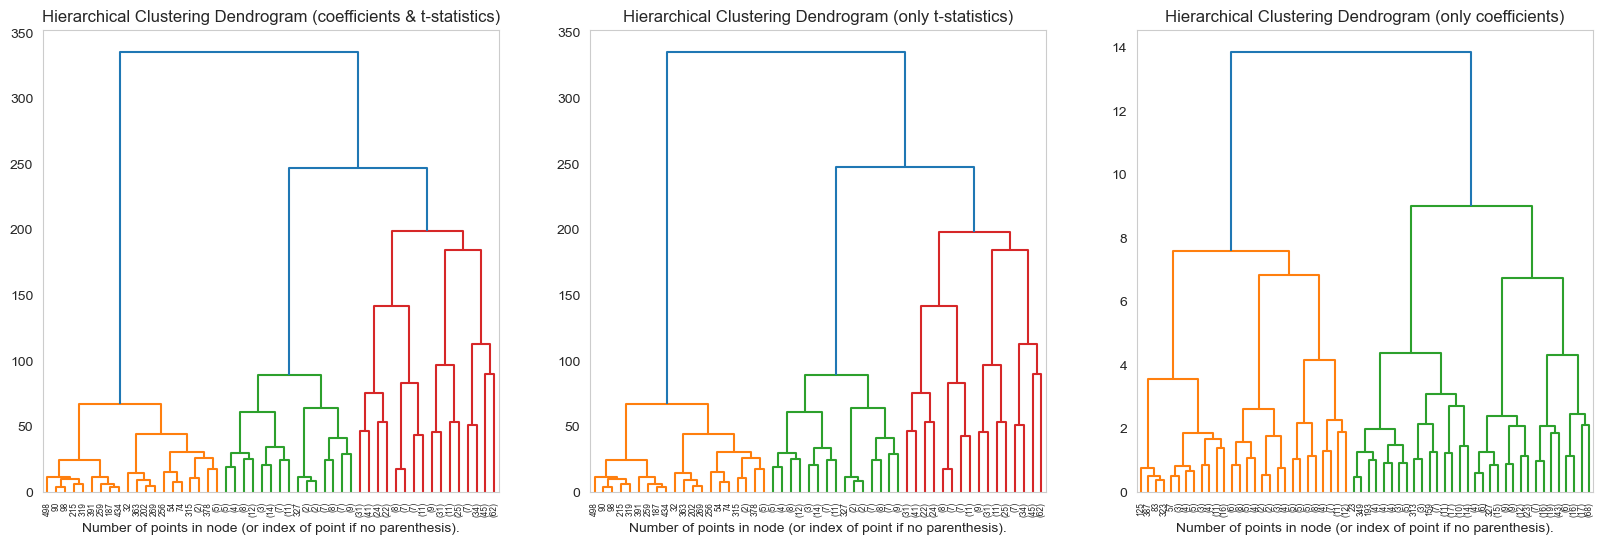

In [16]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



colranges = [(1, 13), (7,13), (1,7)]
titles = ["(coefficients & t-statistics)", "(only t-statistics)", "(only coefficients)"]
fig, axs = plt.subplots(1, 3, figsize = (20, 6))
coef_names = df_ols_results.columns[1:(len(axs)+1)]
sns.set_style("whitegrid")
for i, (ax, (col_min, col_max)) in enumerate(zip(axs,colranges)):
    df_ff_clustering = df_ols_results.copy()
    cols_of_interest = df_ols_results.columns[col_min:col_max]
    df_ff_clustering = df_ff_clustering[cols_of_interest]

    # setting distance_threshold=0 ensures we compute the full tree.
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

    model = model.fit(df_ff_clustering)
    ax.set_title(f"Hierarchical Clustering Dendrogram {titles[i]}")
    # plot the top three levels of the dendrogram
    plot_dendrogram(model, truncate_mode="level", p=5, ax= ax)
    ax.grid(False)
    ax.set_xlabel("Number of points in node (or index of point if no parenthesis).")

## Clustering based on features extracted from returns time series

No clear differences among the different time series -> difficult to cluster

In [17]:
returns.fillna(0)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-01-05,-1.092214,10.724572,-0.596107,0.172755,0.000000,-0.715993,-0.811225,-0.334110,0.616146,...,5.904144,-1.193089,0.389692,-1.195990,0.000000,-0.342586,3.116513,-0.174548,3.465168,0.000000
2,2010-01-06,-0.355917,-4.231410,0.868152,-1.603405,0.000000,-0.950075,0.553827,-0.433244,1.057429,...,-1.320423,0.191868,0.860618,0.656748,0.000000,-0.717456,-0.032283,-0.771667,8.338101,0.000000
3,2010-01-07,-0.129752,2.904329,-0.024703,-0.185038,0.000000,-1.616637,0.825017,-0.589966,-0.093541,...,2.113119,-0.432195,-0.314705,1.300461,0.000000,-0.028811,2.268079,-2.531778,10.616026,0.000000
4,2010-01-08,-0.032510,-1.926811,0.394472,0.662601,0.000000,1.080663,0.509921,-0.197437,-0.398564,...,-0.719028,0.048126,-0.401974,0.000000,0.000000,0.028811,-2.122802,-0.325557,-1.631940,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,2023-03-27,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,...,-0.225442,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596
3330,2023-03-28,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,...,0.814805,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149
3331,2023-03-29,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,...,1.701700,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560
3332,2023-03-30,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,...,-0.045864,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838


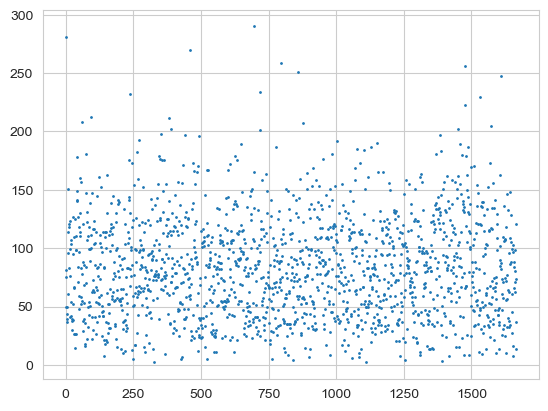

In [18]:
from scipy.fft import fft

stocks = returns.columns[1:] # Excludes Date
X = returns[stocks].fillna(0)
ys = []
for i, stock in enumerate(stocks):
    vals = X[stock].to_numpy()
    y = fft(vals)
    ys.append(y)
ys = np.array(ys)
intensity_freqs = abs(ys)[:, :ys.shape[1]//2]
y = intensity_freqs[111]
plt.scatter(range(len(y)), y, s = 1)
plt.show()

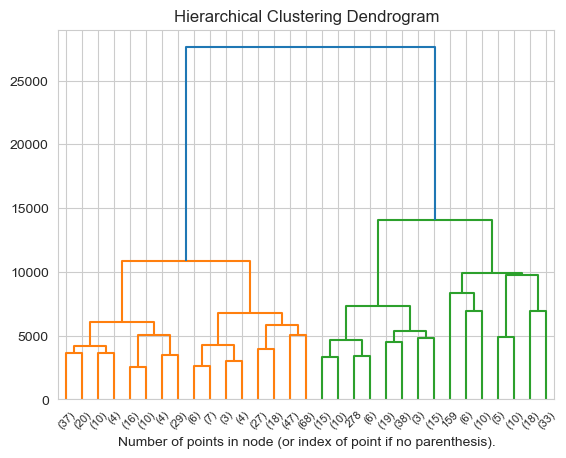

In [19]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(intensity_freqs)
plt.title(f"Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=4)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Clustering based on raw returns time series

Difficult to extract common characteristics out of the raw time series.

In [20]:
stocks = returns.columns[1:] # Excludes Date
X = df[stocks]

,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,ADBE,...,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS,y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10
1,-1.092214,10.724572,-0.596107,0.172755,0.172755,-0.715993,-0.811225,-0.334110,0.616146,1.631272,...,-1.193089,0.389692,-1.195990,-1.195990,-0.342586,3.116513,-0.174548,3.465168,3.465168,1
2,-0.355917,-4.231410,0.868152,-1.603405,-1.603405,-0.950075,0.553827,-0.433244,1.057429,-0.212432,...,0.191868,0.860618,0.656748,0.656748,-0.717456,-0.032283,-0.771667,8.338101,8.338101,1
3,-0.129752,2.904329,-0.024703,-0.185038,-0.185038,-1.616637,0.825017,-0.589966,-0.093541,-1.959530,...,-0.432195,-0.314705,1.300461,1.300461,-0.028811,2.268079,-2.531778,10.616026,10.616026,1
4,-0.032510,-1.926811,0.394472,0.662601,0.662601,1.080663,0.509921,-0.197437,-0.398564,-0.543629,...,0.048126,-0.401974,0.000000,0.000000,0.028811,-2.122802,-0.325557,-1.631940,-1.631940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3329,0.837650,1.590773,3.467113,-1.236952,-0.304236,0.178861,0.417280,0.498369,0.717993,-0.483886,...,-0.397436,2.168911,0.748858,0.828295,0.359200,-0.031742,0.045006,3.751748,0.927596,1
3330,-0.331202,0.286533,0.867762,-0.398826,0.449672,0.832565,-1.380599,0.645697,0.378905,0.066975,...,0.168338,1.239921,0.584490,0.561740,0.163563,0.301711,0.445592,2.091842,-0.405149,10
3331,0.915649,2.612226,1.551751,1.959749,-0.158096,0.612047,1.542968,1.470951,1.780423,1.530807,...,1.728100,1.703109,-0.079490,1.499161,-0.070061,0.474533,2.036675,3.574739,-1.452560,1
3332,0.477010,0.832759,0.897704,0.984129,-0.050655,0.232478,0.465358,0.088453,0.966943,0.720049,...,0.554520,0.485234,2.574346,0.902496,0.713899,0.015782,4.293239,-2.412903,0.911838,10


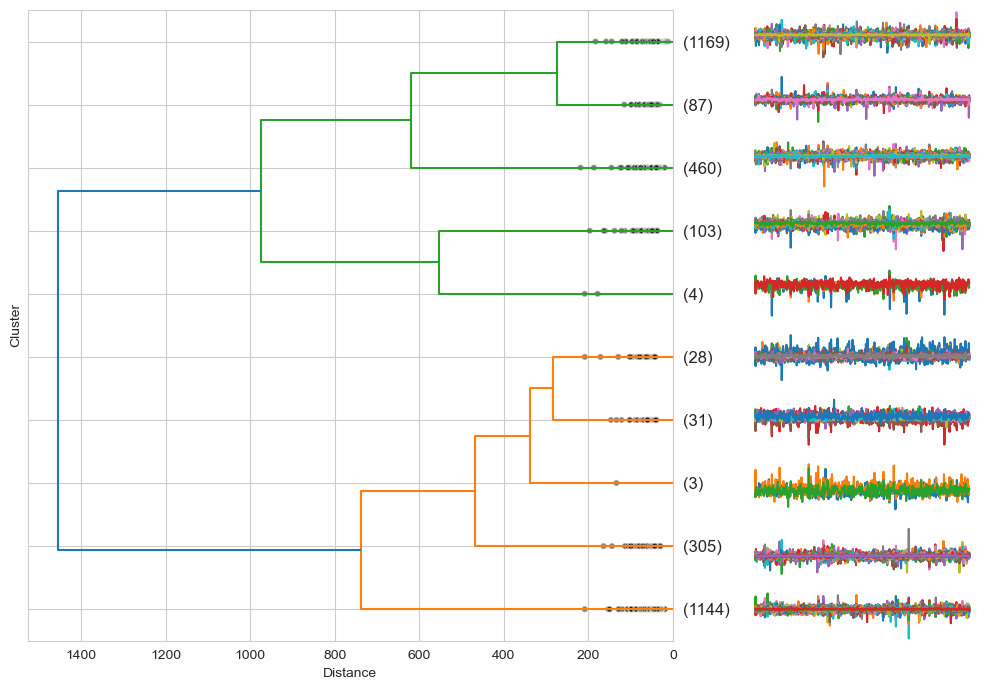

In [21]:
from dendrogram_ts import maxclust_draw

sns.set_style('whitegrid')
plt.figure(figsize=(10,7));

maxclust_draw(X.fillna(method="ffill", axis = 1), 'ward', metric= "euclidean", max_cluster=10, ts_hspace=3)

# 6. Sort the estimated constants and provide the names of the five companies with the highest constant and the five with lowest constant. Comment.

In [22]:

def print_top_bottom_5(df_ols_results):
    df_constants = df_ols_results[["stock", "beta_const"]]
    df_constants = df_constants.sort_values(by ="beta_const", ascending=False)
    top_5 = df_constants.iloc[:5]
    bottom_5 = df_constants.iloc[-5:]

    print("############## Top 5 Companies ###############")
    i = 1
    for _, row in top_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        print(f"{i}. {name} (constant: {const: .3f})")
        i += 1
    
    print("############ Bottom 5 Companies ##############")
    i = 0
    for _, row in bottom_5.iterrows():
        stock, const = row
        ticker = yf.Ticker(stock)
        name = ticker.get_info()["longName"]
        print(f"{496+i}. {name} (constant: {const: .3f})")
        i += 1

In [23]:
print_top_bottom_5(df_ols_results)

############## Top 5 Companies ###############
1. GE HealthCare Technologies Inc. (constant:  0.325)
2. Constellation Energy Corporation (constant:  0.221)
3. Moderna, Inc. (constant:  0.177)
4. Tesla, Inc. (constant:  0.093)
5. Carrier Global Corporation (constant:  0.093)
############ Bottom 5 Companies ##############
496. WestRock Company (constant: -0.078)
497. APA Corporation (constant: -0.080)
498. Carnival Corporation & plc (constant: -0.081)
499. DISH Network Corporation (constant: -0.082)
500. Norwegian Cruise Line Holdings Ltd. (constant: -0.087)


# 7. Temporally aggregating your returns to monthly frequency and taking monthly Fama-French data, redo the analysis and compare your findings with the daily frequency results.

## 7.1 Get monthly data

In [88]:
# Download monthly data from 2010 onwards up to last day of FF
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2023, 4, 1) # Last day of FF
data_monthly = yf.download(tickers, start = start, end = end, interval="1mo")
prices_monthly = data_monthly["Adj Close"].reset_index()
# Drop columns without any data
prices_monthly = prices_monthly.drop(["BF.B", "BRK.B", "HON"], axis=1)

[*********************100%***********************]  504 of 504 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted


In [89]:
# Compute log-prices and log-returns
returns_monthly = prices_monthly.copy()
returns_monthly.iloc[:,1:] = np.log(prices_monthly.iloc[:,1:])
Returns_monthly = np.diff(returns_monthly.iloc[:,1:],axis=0)*100  #times 100 so we get returns in percentage 
# We assume the first return to be 0
Returns_monthly = np.vstack((np.zeros(Returns_monthly.shape[1]),Returns_monthly))
returns_monthly.iloc[:,1:] = Returns_monthly
# Isolate S&P 500
sp500_monthly = returns_monthly[["Date","^GSPC"]]
returns_monthly = returns_monthly.drop("^GSPC", axis = 1)
returns_monthly

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABT,ACGL,ACN,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,11.544114,32.238363,3.364853,6.334700,NaN,2.821187,3.227322,3.353810,-2.519853,...,2.694458,0.144250,0.880788,-1.320966,NaN,-0.857488,1.777434,9.042188,-2.292840,NaN
2,2010-03-01,8.904901,0.272490,2.708033,13.843089,NaN,3.385085,-2.991983,3.022261,4.834892,...,17.635238,1.856790,3.650941,5.268277,NaN,12.814179,3.209763,3.541717,16.436826,NaN
3,2010-04-01,5.294947,-3.883975,7.448536,10.527944,NaN,6.460350,-2.927768,-0.882576,3.949551,...,15.156644,3.707298,1.172536,5.094668,NaN,10.138706,2.847581,-1.875592,27.419852,NaN
4,2010-05-01,-11.379212,22.229434,13.773548,-1.625612,NaN,1.384225,-6.457697,-2.763417,-14.236108,...,-5.067294,-5.967683,-11.413755,-12.232936,NaN,-3.015316,-8.529647,-5.483245,-18.197325,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,11.350930,1.747685,-22.938928,-3.524271,9.617915,8.220295,8.372114,4.105849,5.825561,...,26.944162,7.555503,0.477155,-1.833710,9.243934,8.437227,5.784435,-4.676553,-0.231301,2.203946
155,2022-12-01,-3.499686,-12.613382,-2.657701,-13.041916,0.266432,-2.960975,2.033468,4.679310,-12.022844,...,-1.432640,-0.156774,-0.938460,5.089665,-1.597018,-0.451821,5.979165,-5.268071,-5.269589,-5.049459
156,2023-01-01,1.610752,23.812505,3.508428,10.482933,-8.966437,1.942273,0.689848,2.470038,4.474172,...,22.848874,-1.929789,5.047246,14.558941,-6.116173,1.879473,-0.125572,20.953391,7.822595,12.154412
157,2023-02-01,-6.879093,-0.996271,-4.926303,2.139273,4.078134,-8.263055,-8.324398,8.415833,-4.958783,...,4.462797,-6.301765,-5.401453,3.311378,-1.316191,-2.600365,-2.762800,-5.169619,-4.895950,0.908301


In [90]:
# Read monthly FF data
ff_monthly = pd.read_csv("./data/F-F_Research_Data_5_Factors_2x3.csv")
ff_monthly = ff_monthly.rename({"Unnamed: 0": "Date"}, axis = 1)
ff_monthly["Date"] = pd.to_datetime(ff_monthly["Date"], format="%Y%m")
# Merge dataframes based on date
df_monthly = pd.merge(ff_monthly, returns_monthly, on = "Date", how = "inner", suffixes=["_FF", ""])
df_monthly

,Date,Mkt-RF,SMB,HML,RMW,CMA_FF,RF_FF,A,AAL,AAP,...,WYNN,XEL,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,2010-01-01,-3.36,0.34,0.43,-1.27,0.46,0.00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2010-02-01,3.40,1.51,3.23,-0.27,1.43,0.00,11.544114,32.238363,3.364853,...,2.694458,0.144250,0.880788,-1.320966,NaN,-0.857488,1.777434,9.042188,-2.292840,NaN
2,2010-03-01,6.31,1.85,2.21,-0.65,1.69,0.01,8.904901,0.272490,2.708033,...,17.635238,1.856790,3.650941,5.268277,NaN,12.814179,3.209763,3.541717,16.436826,NaN
3,2010-04-01,2.00,4.98,2.89,0.69,1.72,0.01,5.294947,-3.883975,7.448536,...,15.156644,3.707298,1.172536,5.094668,NaN,10.138706,2.847581,-1.875592,27.419852,NaN
4,2010-05-01,-7.89,0.04,-2.44,1.30,-0.22,0.01,-11.379212,22.229434,13.773548,...,-5.067294,-5.967683,-11.413755,-12.232936,NaN,-3.015316,-8.529647,-5.483245,-18.197325,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,2022-11-01,4.60,-2.67,1.38,6.01,3.11,0.29,11.350930,1.747685,-22.938928,...,26.944162,7.555503,0.477155,-1.833710,9.243934,8.437227,5.784435,-4.676553,-0.231301,2.203946
155,2022-12-01,-6.41,-0.16,1.32,0.09,4.19,0.33,-3.499686,-12.613382,-2.657701,...,-1.432640,-0.156774,-0.938460,5.089665,-1.597018,-0.451821,5.979165,-5.268071,-5.269589,-5.049459
156,2023-01-01,6.65,4.43,-4.05,-2.62,-4.53,0.35,1.610752,23.812505,3.508428,...,22.848874,-1.929789,5.047246,14.558941,-6.116173,1.879473,-0.125572,20.953391,7.822595,12.154412
157,2023-02-01,-2.58,0.69,-0.78,0.90,-1.41,0.34,-6.879093,-0.996271,-4.926303,...,4.462797,-6.301765,-5.401453,3.311378,-1.316191,-2.600365,-2.762800,-5.169619,-4.895950,0.908301


## 7.1 Estimate regression coefficients

In [91]:
X_monthly = prepare_data_ols(df_monthly)
df_ols_results_monthly = ols_estimation(df_monthly, X_monthly, returns_monthly)
df_ols_results_monthly

,stock,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
0,A,0.034581,1.202207,-0.021469,-0.142749,-0.254367,0.033885,0.082896,12.280153,-0.113487,-0.838453,-1.110805,0.129042,0.542523
1,AAL,-0.578592,1.073556,1.140406,0.492173,0.536293,0.256028,-0.587942,4.648587,2.555418,1.225451,0.992774,0.413314,0.260124
2,AAP,-0.330185,0.783308,0.757580,0.269934,1.034762,-0.168843,-0.526764,5.325062,2.665182,1.055193,3.007361,-0.427929,0.299882
3,AAPL,0.653220,1.130881,-0.165631,-0.450211,0.767153,-0.253202,1.359531,10.029515,-0.760172,-2.295944,2.908693,-0.837195,0.473481
4,ABBV,0.607312,0.787096,0.141258,-0.130891,0.184237,0.562914,0.957108,5.050440,0.492724,-0.525382,0.512985,1.456971,0.220003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,YUM,0.097986,0.804871,0.218110,0.075013,0.994830,-0.173436,0.236573,8.280544,1.161223,0.443762,4.375564,-0.665225,0.419297
496,ZBH,-0.394586,1.000646,-0.062256,0.063636,-0.460647,0.356603,-0.896768,9.690643,-0.312005,0.354368,-1.907188,1.287518,0.429147
497,ZBRA,0.280682,1.285933,0.677035,0.077358,0.297635,-1.078319,0.491553,9.596389,2.614612,0.331955,0.949569,-3.000081,0.525081
498,ZION,-0.181296,1.059154,0.871975,1.732581,-0.744285,-1.116808,-0.396429,9.868917,4.204562,9.282960,-2.964849,-3.879582,0.720688


## 7.2 Summary statistics

In [92]:
df_ols_results_monthly.describe()

,beta_const,beta_Mkt-RF,beta_SMB,beta_HML,beta_RMW,beta_CMA_FF,t_const,t_Mkt-RF,t_SMB,t_HML,t_RMW,t_CMA_FF,R2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.044707,0.986839,0.113006,0.197670,0.068180,-0.073852,0.104412,8.348625,0.299194,0.939821,0.363375,-0.107473,0.417234
std,0.687141,0.341315,0.404973,0.608753,0.473682,0.599929,1.085387,3.014417,1.619691,2.897385,1.690222,1.847217,0.160397
min,-2.601526,-0.526925,-1.970573,-2.015588,-2.078333,-2.364885,-3.188439,-0.000000,-4.822235,-5.273745,-5.674295,-6.200279,0.016308
25%,-0.321796,0.766751,-0.165956,-0.191980,-0.233894,-0.449449,-0.587479,6.144971,-0.782661,-0.971742,-0.775275,-1.284851,0.292334
50%,0.054444,0.975962,0.108718,0.088188,0.117142,-0.012870,0.096816,8.197359,0.413082,0.447381,0.396845,-0.046415,0.418315
75%,0.418495,1.202218,0.359852,0.500420,0.400281,0.306321,0.858763,10.250711,1.426360,2.145407,1.536925,0.977638,0.531235
max,4.781433,2.276295,1.685775,2.468073,1.481889,1.506902,2.702803,17.221245,5.047637,11.578243,4.937873,5.070150,1.000000


## 7.3 Plot KDEs of statistics

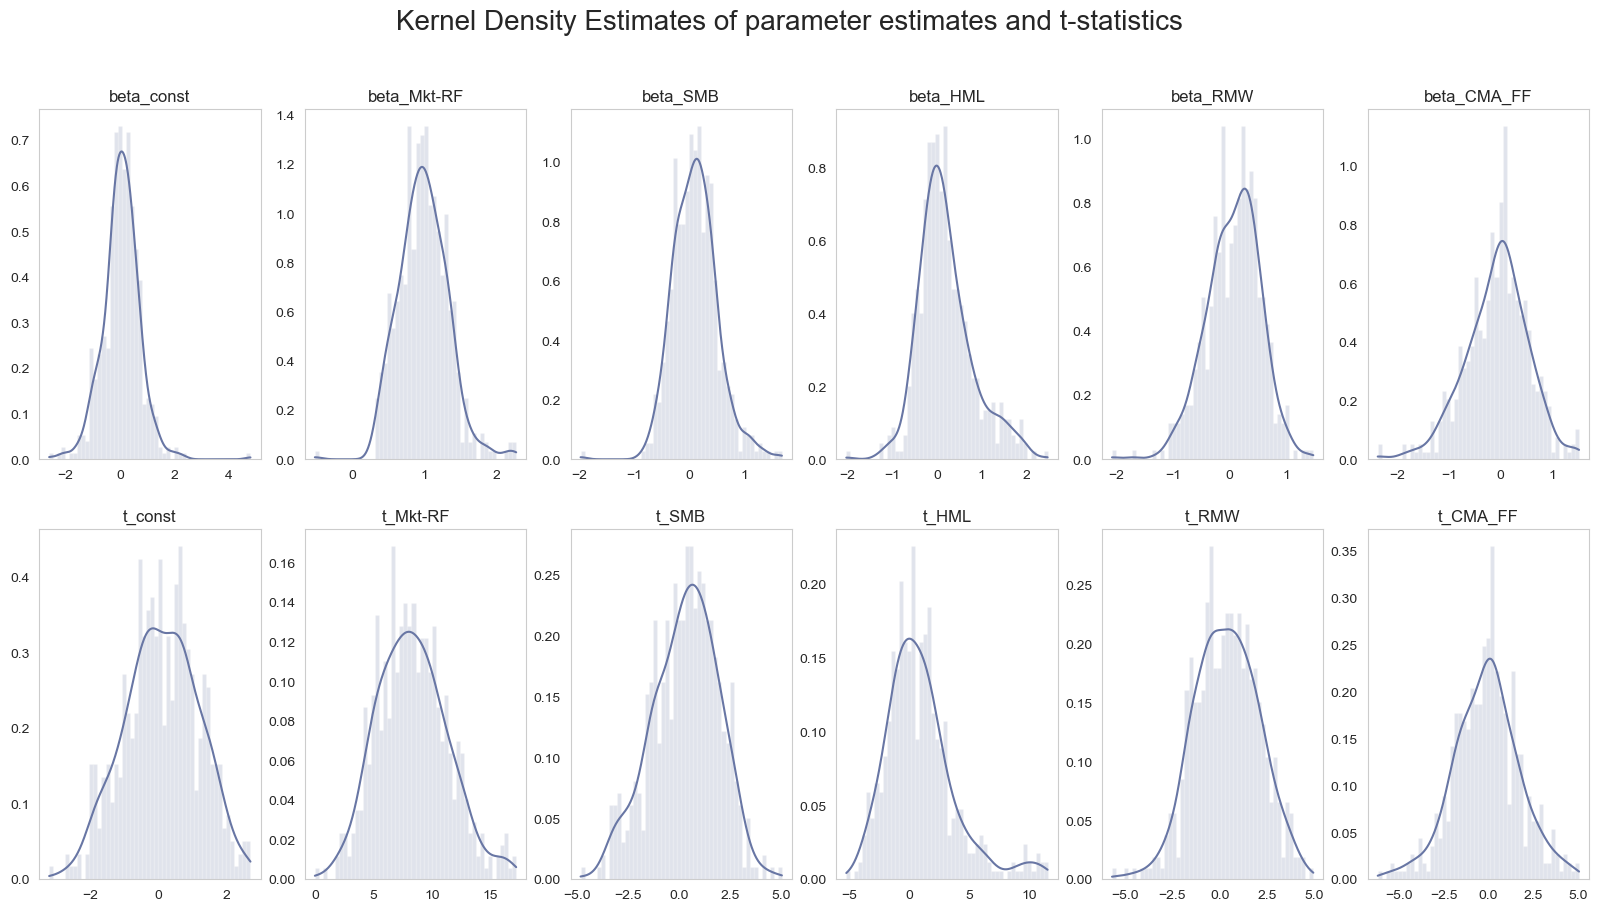

In [93]:
kde_statistics(df_ols_results_monthly)

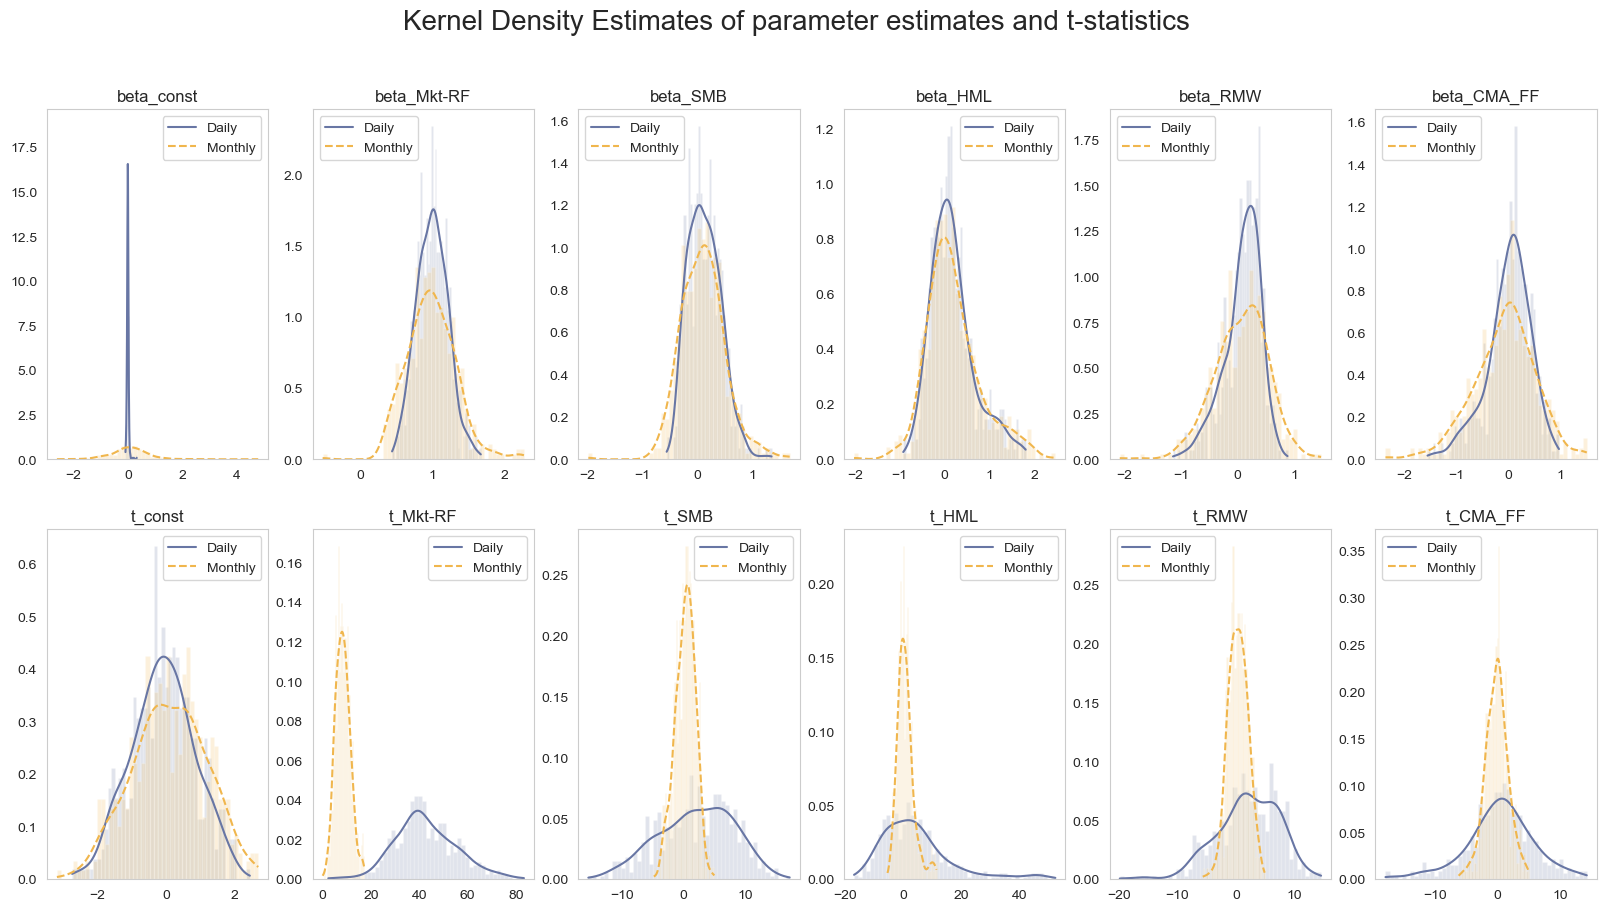

In [94]:
kde_statistics(df_ols_results, df_ols_results_monthly)

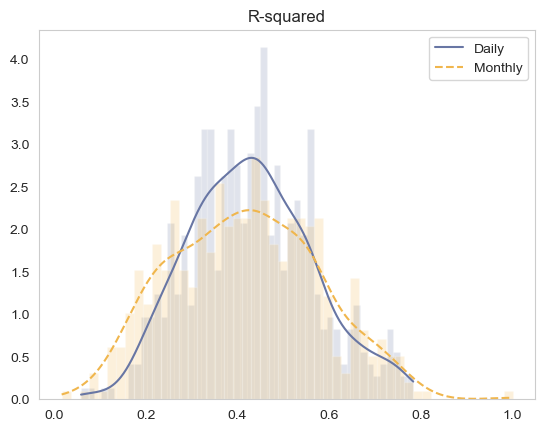

In [99]:
plot_r_squared(df_ols_results, df_ols_results_monthly)

**Outlier due to GEHC 3 data points with 5 regressors.**

## 7.4 Differences between sectors

In [ ]:
df_results_sectors_monthly = add_sector(df_ols_results_monthly)

0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
0 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
1 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
2 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
3 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
4 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin
5 violin


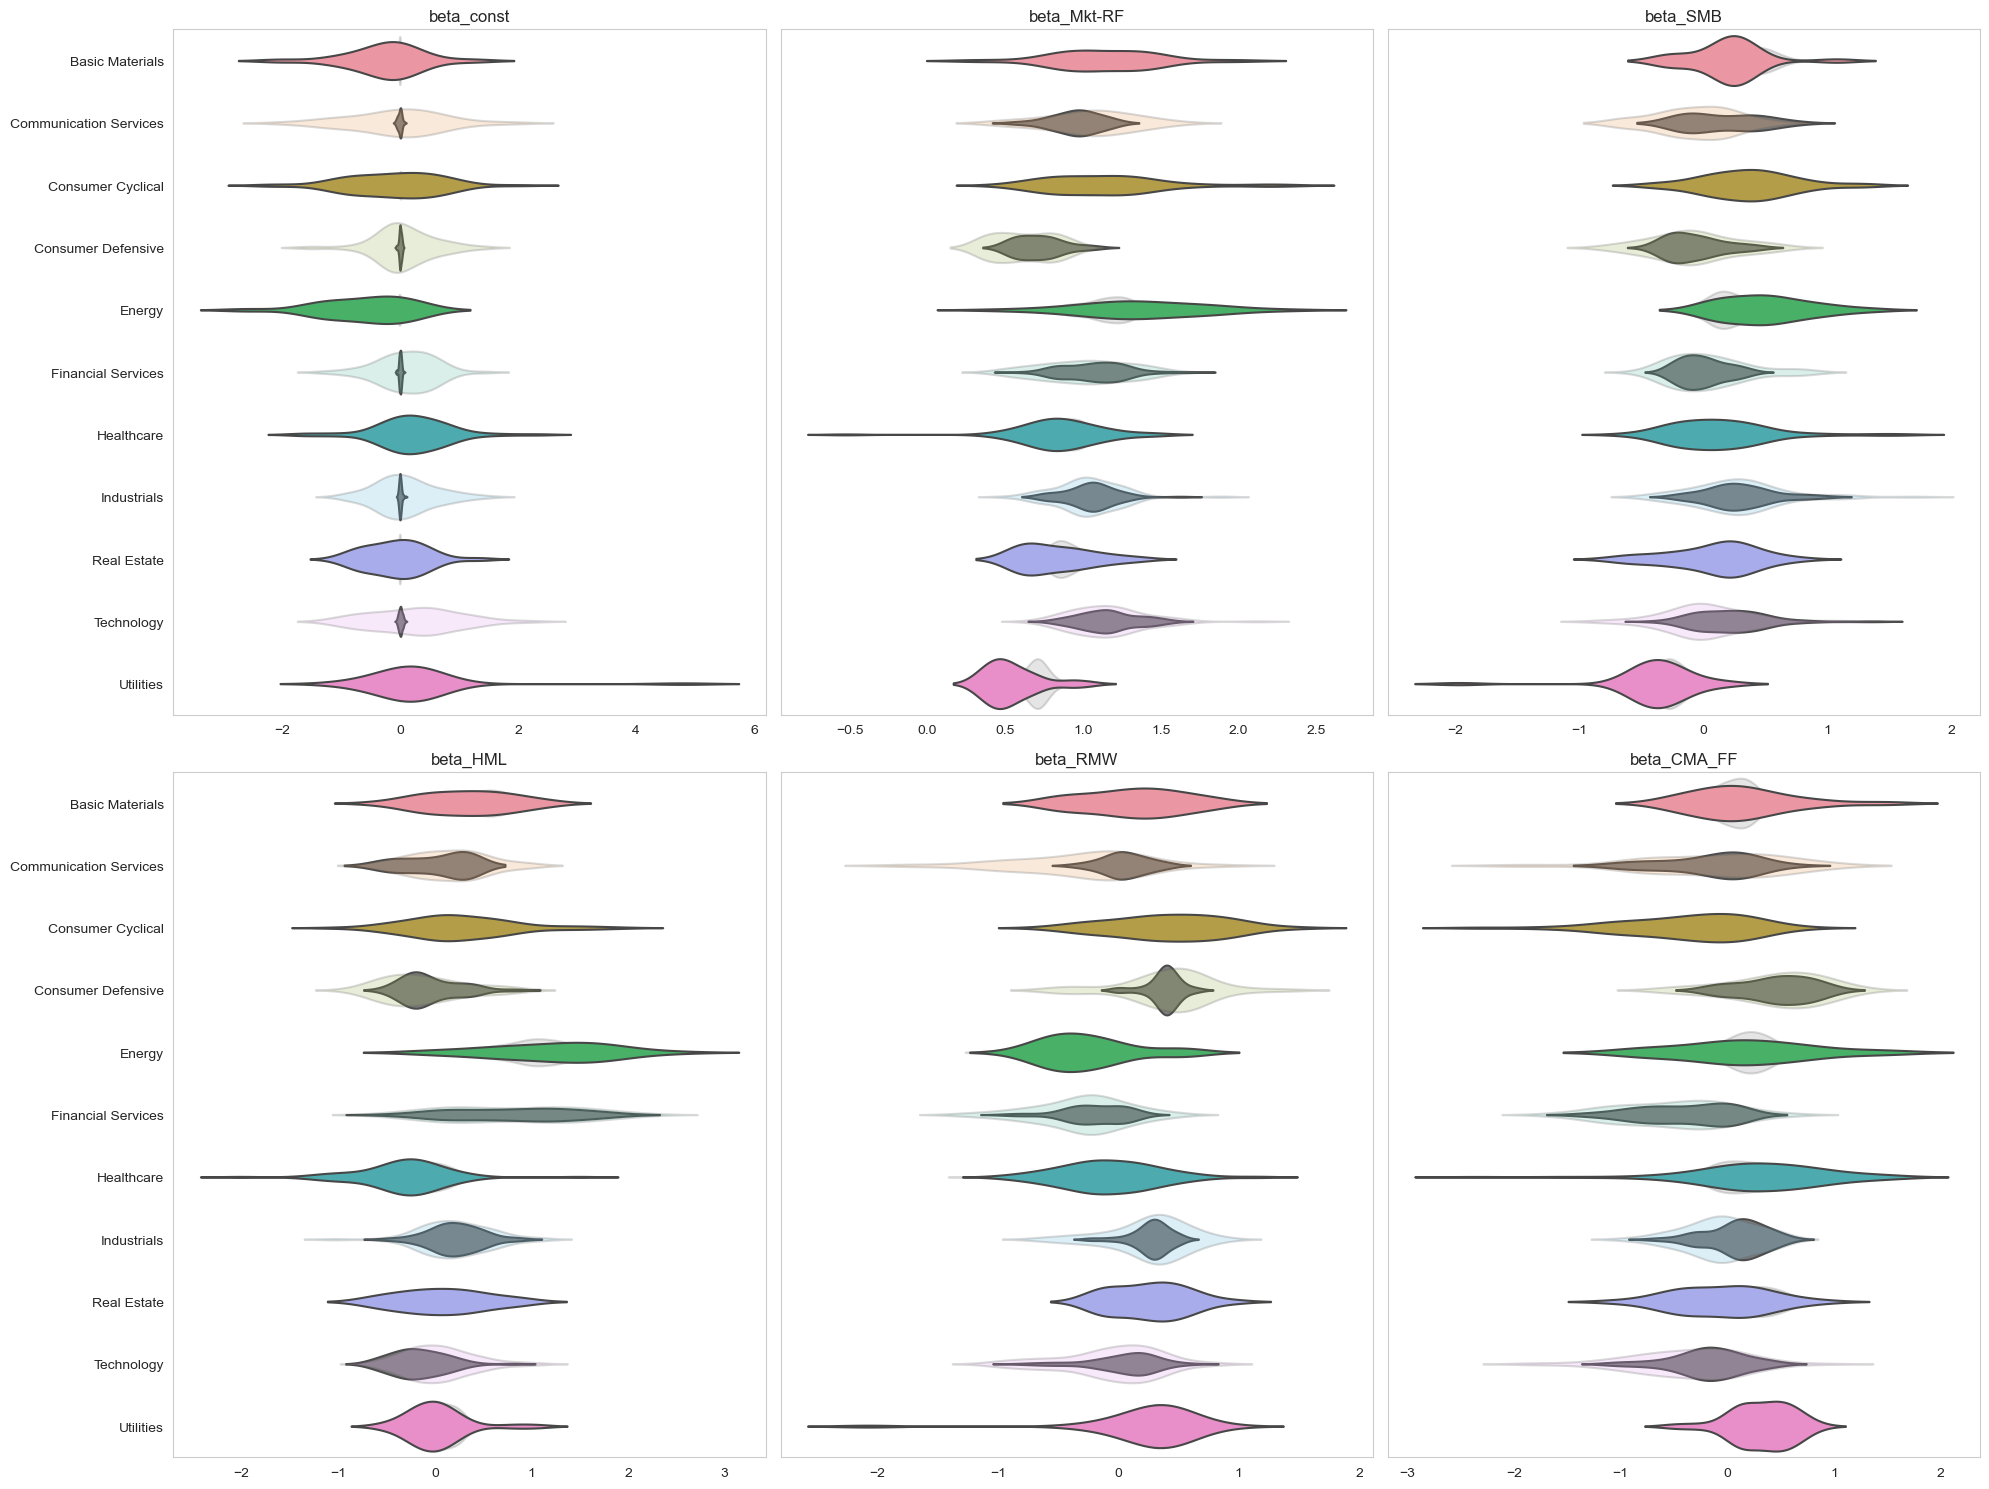

In [145]:
plot_violin_sector(df_results_sector, df_results_sectors_monthly)